In [125]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import chart_studio.plotly as py
import nibabel
import seaborn as sns; sns.set()
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.feature_selection import SelectFromModel

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
tfd = tfp.distributions
tfpl = tfp.layers


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve, auc, precision_score, recall_score, f1_score
from tensorflow.python.ops.summary_ops_v2 import keras_model
from sklearn.metrics import roc_curve
from tensorflow.keras.layers import BatchNormalization
from numpy import interp
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve


In [126]:
#Some Functions
def rfr_model(X, y):
    # Perform Grid-Search
    n_estimators = [10, 100, 1000]
    max_features = [1,60] 
    grid = dict(n_estimators=n_estimators,max_features=max_features)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    gsc = GridSearchCV( estimator=RandomForestClassifier(), 
                    param_grid={'max_depth': range(3,20),'n_estimators': (10, 50, 100, 1000),}, 
                    cv=cv, scoring='roc_auc',
                    verbose=0, 
                    n_jobs=-1)
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    rfr = RandomForestClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_absolute_error')
    #predictions = cross_val_predict(rfr, X, y, cv=10)
    return best_params, rfr, scores
    
def plot_roc(model, X_test, y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probabilities = model.predict_proba(np.array(X_test))
    predictions = probabilities[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.01, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def roc_curvy(classifier, n_splits, X, y ):
    cv = StratifiedKFold(n_splits= n_splits)
    tprs = []       #True positive rates
    aucs_rf = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs_rf.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr= np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc_rf = auc(mean_fpr, mean_tpr)
    std_auc_rf = np.std(aucs_rf)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rf, std_auc_rf),
            lw=2, alpha=.8)

    std_tpr_rf = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr_rf, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr_rf, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example")
    ax.legend(loc="right", bbox_to_anchor=(1.5, 0.5))
    plt.show()


def learning_curves(estimator, X, y, train_sizes, cv, scoring):
    train_sizes = [10,30, 60, 90, 100,130, 160, 190, 220, 260, 294]
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, X, y, train_sizes = train_sizes,
                                                 cv = cv, scoring = scoring)
    #print('Training scores:\n\n', train_scores)
    #print('\n', '-' * 70) # separator to make the output easy to read
    #print('\nValidation scores:\n\n', validation_scores)
    train_scores_mean = -train_scores.mean(axis = 1)
    #print(train_scores_mean)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    #print(validation_scores_mean)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel(scoring, fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()

In [127]:
# Dataset Import
p0 = pd.read_csv('HL_Prostate_3Gy_2arc.csv')    #-->>{230}  460 inuts
p1 = pd.read_csv('HL_Prostate_3Gy_1arc.csv')    #-->>{77}
p2 = pd.read_csv('TB_Prostate_2Gy_1arc.csv')    #-->>{132}
p3 = pd.read_csv('TB_Prostate_27Gy_1arc.csv')   #-->>{69}
p4 = pd.read_csv('TB_Prostate_3Gy_1arc.csv')    #-->>{72} 
d_hl = pd.read_csv('detectors/HL4-Table 1.csv')


In [128]:
# DATASETS
#p0 = pd.read_csv('HL_Prostate_3Gy_2arc.csv')    #-->>{230}  460 inuts
#p1 = pd.read_csv('HL_Prostate_3Gy_1arc.csv')    #-->>{77}
#p2 = pd.read_csv('TB_Prostate_2Gy_1arc.csv')    #-->>{132}
#p3 = pd.read_csv('TB_Prostate_27Gy_1arc.csv')   #-->>{69}
#p4 = pd.read_csv('TB_Prostate_3Gy_1arc.csv')    #-->>{72} 
#hn = pd.read_csv('HN.csv')                      #-->>{35}   70 inputs
#b = pd.read_csv('Brain.csv')                    #-->>{38}   76 inputs
#t = pd.read_csv('TB_Thorax_2arc.csv')           #-->>{8}    16 inputs
#all_p = pd.read_csv('all_prostate_data.csv')



#p = pd.read_csv('P.csv')
#p5 = pd.read_csv('dose.csv')                    #-->>{141}  // {TB 3Gy 1 ARC}
#p6 = pd.read_csv('anatomy.csv')
######################################
# df.value_counts(), df.unique()
#p0.columns.symmetric_difference(p1.columns) -->> Find the different columns between each dataset
#p0 = p0.fillna(value=p0.mean())
#p1 = p1.fillna(value=p1.mean())
###################################
#a1 = np.intersect1d(p0.columns, p1.columns)
#p_halcyon= pd.concat((p0[a1],p1[a1]), axis=0, ignore_index=True)        ###--->>> Halcyon dataset
#p_halcyon
###################################
#p2 = p2.fillna(value=p2.mean())
#p3 = p3.fillna(value=p3.mean())
#p4 = p4.fillna(value=p4.mean())
###################################
#a2 = np.intersect1d(p2.columns, p3.columns)
#p_= pd.concat((p2[a2],p3[a2]), axis=0, ignore_index=True)
#a3 = np.intersect1d(p_.columns, p4.columns)
#p_mlinac = pd.concat((p_[a3],p4[a3]), axis=0, ignore_index=True)        ###--->>> matched-linacs dataset
##p_mlinac
####################################
#a4 = np.intersect1d(p_halcyon.columns, p_mlinac.columns)
#p = pd.concat((p_halcyon[a4],p_mlinac[a4]), axis=0, ignore_index=True)  ###--->>> All prostate dataset
####p.to_csv('all_prostate_data.csv', index=False)
#
#
###################################
## The prostate dataset for each detector                                ###--->>> Each detector for prostate
#tb6 = p.loc[p['Detector'] == 'TB6']
#cl1 = p.loc[p['Detector'] == 'CL1']
#cl4 = p.loc[p['Detector'] == 'CL4']
#cl2 = p.loc[p['Detector'] == 'CL2']
#cl5 = p.loc[p['Detector'] == 'CL5']
# The H&N dataset for each detector                                ###--->>> Each detector for H&N
#tb6_hn = hn.loc[hn['Detector'] == 'TB6']
#cl1_hn = hn.loc[hn['Detector'] == 'CL1']
#cl4_hn = hn.loc[hn['Detector'] == 'CL4']
#cl2_hn = hn.loc[hn['Detector'] == 'CL2']
#cl5_hn = hn.loc[hn['Detector'] == 'CL5']
## The Brain dataset for each detector                                ###--->>> Each detector for H&N
#tb6_b = b.loc[b['Detector'] == 'TB6']
#cl1_b = b.loc[b['Detector'] == 'CL1']
#cl4_b = b.loc[b['Detector'] == 'CL4']
#cl2_b = b.loc[b['Detector'] == 'CL2']
#cl5_b = b.loc[b['Detector'] == 'CL5']
#
#
#### HETEROGENEITY --->>> NUMBER OF ARCS
#### halcyon plans
#hl_1arc = p1[a4]            #--(N= 77)
#hl_2arc = p0[a4]            #--(N= 230->460)
#
#
#### HETEROGENEITY --->>> DOSE PER FRACTION
#### dosimetrically-matched linacs
#p_2g = p_mlinac.loc[p_mlinac['Dose']==2]                                    #--(N= 131)                             
#p_3_g = p_mlinac.loc[p_mlinac['Dose']==3]
#p_27g = p_mlinac.loc[p_mlinac['Dose']== 2.75]
#p_25g = p_mlinac.loc[p_mlinac['Dose']== 2.5]
#p_63g = p_mlinac.loc[p_mlinac['Dose']== 2.63]
#p_3g = pd.concat((p_3_g,p_27g, p_25g, p_63g ), axis=0, ignore_index=True)   #--(N= 141)
#
#
#### HETEROGENEITY --->>> TREATMENT UNITS
#### dosimetrically-matched linacs
##hl_1arc                            #-->>(N= 77)
#ml_3gy = tb6.loc[tb6['Dose']==3]                               #-->>(N=75)
#
#### HETEROGENEITY --->>> TANATOMICAL REGION
#### dosimetrically-matched linacs
#a5 = np.intersect1d(hn.columns, b.columns)
##anatomic_region
#ar = pd.concat((b[a5], hn[a5]), axis=0, ignore_index=True)      #-->>(N=146) H& and Bran plans
#a6 = np.intersect1d(p2.columns, ar.columns)
#ar = ar[a6]
#p_ar = p2[a6]
#ar = ar.fillna(value=ar.mean())
#p_ar = p_ar.fillna(value=ar.mean())
# all = pd.concat((p2[a6], ar[a6]), axis=0, ignore_index=True) 
#
#
#
#### REFERENCE MODEL --->>> BASE-LINE CONDITIONS
#a8 = np.intersect1d(all_p.columns, ar.columns)
#bl = pd.concat((all_p[a8].sample(100), ar[a8]), axis=0, ignore_index=True)
##bl = bl.sample(184) #---->>> Base Line model
##bl.to_csv('reference_mode.csv', index=False)

#al = pd.concat((all_p[a8], ar[a8]), axis=0, ignore_index=True)
#


<AxesSubplot:xlabel='MU', ylabel='2_1'>

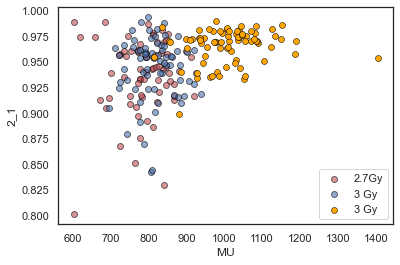

In [129]:
sns.set_style("white")
sns.scatterplot(data=p3, x='MU', x_jitter=True, y='2_1', color='r', edgecolor='black', linewidth=0.9, alpha=0.6, label='2.7Gy')
sns.scatterplot(data=p4, x='MU', x_jitter=True, y='2_1', color='b', edgecolor='black', linewidth=0.9, alpha=0.6, label='3 Gy')
sns.scatterplot(data=p1, x='MU', x_jitter=True, y='2_1', color='orange', edgecolor='black', linewidth=0.5, label='3 Gy')

In [130]:
p2 = p0.fillna(p0.mean())
p2 = p2.dropna(axis='columns')
G = np.array(p2['2_1'])
mu=[0 if x <= 0.98 else 1 for x in G]
#plt.hist(mu)

/Users/pauloalejandroquinteromejia/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [131]:
df = p2
x = pd.get_dummies(df.Detector, prefix='Detector')
#y = pd.get_dummies(df.Anatomy, prefix='Anatomy')
z = pd.get_dummies(df.ARC, prefix='ARC')
df = pd.concat((df,x, z), axis= 1)
df = df.drop(columns=['3_3', '3_2', '2_3', '2_2', 'Detector', 'ARC'])
#p2 = p2.drop(columns=['Gamma'])
features= list((df.loc[:, df.columns != '2_1']).columns)
#features= list((p2.loc[:, p2.columns != 'Gamma']).columns)
X = np.array(df[features])
y = np.array(mu)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train) #-->>{104, 188}
X_test = sc.fit_transform(X_test)   #-->>{27, 188}

/Users/pauloalejandroquinteromejia/opt/anaconda3/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


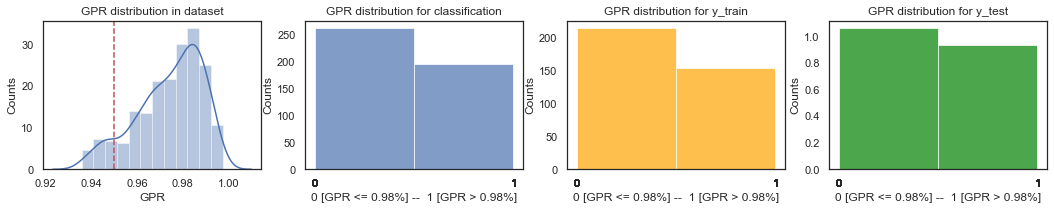

In [132]:
sns.set_style("white")
fig = plt.figure()
fig.set_size_inches(18, 6)
plt.subplot(2,4,1)
plt.title('GPR distribution in dataset')
#sns.distplot(p2["2_2"])
sns.distplot(p2['2_1'])
plt.axvline(x=0.95, c='r', ls='--')
plt.xlabel('GPR')
plt.ylabel('Counts')
plt.subplot(2,4,2)
plt.hist(mu, bins=2, density=False, alpha=0.7)
plt.title('GPR distribution for classification')
plt.ylabel('Counts')
plt.xlabel('0 [GPR <= 0.98%] --  1 [GPR > 0.98%]')
plt.xticks(mu);
plt.subplot(2,4,3)
plt.hist(y_train, bins=2, density=False, alpha=0.7, color='orange')
plt.title('GPR distribution for y_train')
plt.ylabel('Counts')
plt.xlabel('0 [GPR <= 0.98%] --  1 [GPR > 0.98%]')
plt.xticks(y_train);
plt.subplot(2,4,4)
plt.hist(y_test, bins=2, density=2, alpha=0.7, color='green')
plt.title('GPR distribution for y_test')
plt.ylabel('Counts')
plt.xlabel('0 [GPR <= 0.98%] --  1 [GPR > 0.98%]')
plt.xticks(y_test);

In [133]:
l1 = list(y_train)
print('Trainin Passing plans', l1.count(1)/len(l1))
print('Training Failling plans', l1.count(0)/len(l1))

l2 = list(y_test)
print('Testing Passing plans', l2.count(1)/len(l2))
print('Testing Failling plans', l2.count(0)/len(l2))


Trainin Passing plans 0.41847826086956524
Training Failling plans 0.5815217391304348
Testing Passing plans 0.4673913043478261
Testing Failling plans 0.532608695652174


In [135]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_train, y_train)
importances = list(model.feature_importances_)
feature_importances= list(model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
# list of x locations for plotting
x_values = list(range(len(importances)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
cumulative_importances = np.cumsum(sorted_importances)
#print('Number of features for 96% importance:', np.where(cumulative_importances > 0.50)[0][0] + 1)

fig = plt.figure()
fig.set_size_inches(35, 5)
plt.subplot(2,3,1)
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); 
plt.title('Variable Importances');
# Make a line graph
plt.subplot(2,3,2)
#fig = plt.figure()
#fig.set_size_inches(7, 5)
plt.plot(x_values, cumulative_importances, 'g-')
plt.hlines(y = 0.96, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.xticks(x_values, sorted_features, rotation = 'vertical')
plt.xlabel('Variables'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
# Find number of features for cumulative importance of 98%
print('Number of features for 96% importance:', np.where(cumulative_importances > 0.5)[0][0] + 1)

In [137]:
new_features= sorted_features[0:38]
X2 = np.array(df[new_features])
y2 = np.array(mu)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.fit_transform(X_test2)

In [138]:
print('Whole dataset shape', X.shape)
print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Whole dataset shape (460, 287)
Train dataset shape (368, 287)
Test dataset shape (92, 287)


# Neural-Network

In [140]:
model= Sequential()
#model.add(BatchNormalization())
model.add(Dense(187, input_shape= (287,), activation= 'relu', name='layer_1')) #input_shape= (74,)
#model.add(BatchNormalization())
model.add(Dense(33, activation= 'relu', name='layer_2'))
#model.add(Dense(30, activation= 'relu'))
#model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid", name='layer_3'))
auc = tf.keras.metrics.AUC()
model.compile(loss="binary_crossentropy", optimizer= "adam", metrics=[auc]) #'accuracy'
#
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=3)
model.fit(x= X_train, y= y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

<AxesSubplot:>

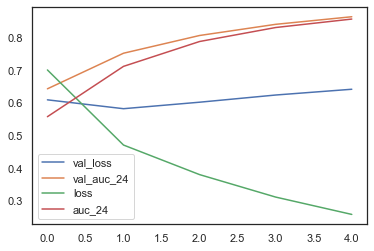

In [141]:
metrics = pd.DataFrame(model.history.history)
metrics.plot()

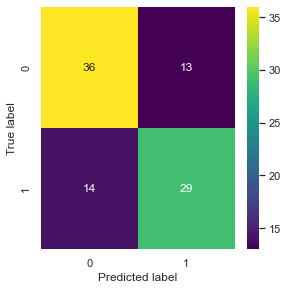

Accuracy 0.7065217391304348
precision 0.6904761904761905
recall 0.6744186046511628
Specificity 0.7346938775510204
f1 0.6823529411764705


In [142]:
#Confussion matrix
classes=[0,1]
y_pred=model.predict_classes(X_test).ravel()
#con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
tn, fp, fn, tp =cm[0][0], cm[0][1], cm[1][0], cm[1][1]
#con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
#con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
figure = plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='viridis')
#tn, fp, fn, tp = confusion_matrix(y_test, predictions_1).ravel()
specificity = tn / (tn+fp)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Accuracy',accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('Specificity', specificity)
print('f1', f1_score(y_test, y_pred))


Epoch 00018: early stopping
Epoch 00013: early stopping
Epoch 00011: early stopping
Epoch 00010: early stopping
Epoch 00013: early stopping


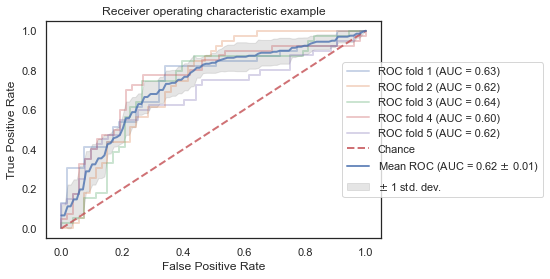

In [143]:
# Neuronal Network AUC - Cross Validation
new_features= sorted_features[0:81]
X = np.array(df[new_features])
y = np.array(mu)
seed =18
np.random.seed(seed)
tprs1 = []
aucs1 = []
fprs1 = []
mean_fpr = np.linspace(0, 1, 100)
i = 1
fig, ax = plt.subplots()
kfold = StratifiedKFold(n_splits=5, shuffle=True) #, random_state=seed)
# for i, (train, test) in enumerate(cv.split(X_13 , target)):
for train, test in kfold.split(X, y):
    !rm -rf ./logs/
  # create model
    model= Sequential()
    #model.add(BatchNormalization())
    model.add(Dense(198, activation= 'relu')) #(119)
    #model.add(BatchNormalization())
    model.add(Dense(33, activation= 'relu'))
    #model.add(Dense(12, activation= 'relu'))
    #model.add(Dense(6, activation= 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
##- compile model    
    auc = tf.keras.metrics.AUC()
    model.compile(loss="binary_crossentropy", optimizer= "adam", metrics=[auc]) #'accuracy'
    early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
    model.fit(x=X[train], y= y[train], validation_data=(X[test], y[test]) ,epochs=600, batch_size=5, verbose=0, callbacks=[early_stop])
    #metrics = pd.DataFrame(model.history.history)
    #metrics.plot()  
# evaluate the model  
    y_pred_keras = model.predict(X[test]).ravel()
 
    fpr, tpr, thresholds = roc_curve(y[test], y_pred_keras)
    #fprs1.append(fpr)
    tprs1.append(interp(mean_fpr, fpr, tpr))

    roc_auc = auc(fpr, tpr)
    #roc_auc5 = metrics.auc(fpr, tpr)
    aucs1.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

#mean_tpr = np.mean
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs1, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs1)
#mean_auc = auc(mean_fpr, mean_tpr)
#roc_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs1)

ax.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
std_tpr = np.std(tprs1, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="right", bbox_to_anchor=(1.5, 0.5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()